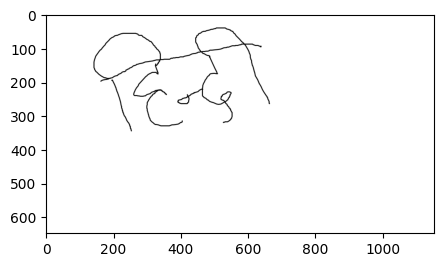

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import warnings
warnings.filterwarnings("ignore")

img = cv2.imread("/content/test.jpg", 0)

def show(img, figsize=(5, 5)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.show()
show(img)


TypeError: 'tuple' object is not callable

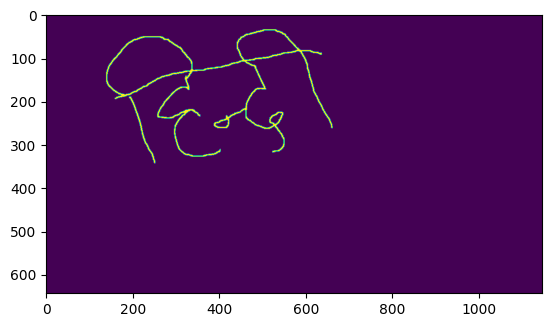

In [ ]:
def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    check = int(bthresh * shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1

    bg = np.repeat(thresh, shape[1])

    count = 0
    for row in range(1, shape[0]):
        bg_reshaped = bg.reshape(1, -1)  # Reshape bg to match the shape of image[row]
        if np.equal(bg_reshaped, image[row]).all():  # Use np.all() to check all elements in the row
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break

    count = 0
    for row in range(shape[0] - 1, 0, -1):
        bg_reshaped = bg.reshape(1, -1)  # Reshape bg to match the shape of image[row]
        if np.equal(bg_reshaped, image[row]).all():  # Use np.all() to check all elements in the row
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if d:
        b = 2
    else:
        b = 0

    return (top, bottom, b)


def preprocess(bgr_img):#gray image
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0

    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]

    plt.imshow(template)
    plt.show()
    return (template, tb, lr)
prepimg, tb, lr = preprocess(img)


In [ ]:
print(img.shape())

TypeError: 'tuple' object is not callable

In [ ]:
def segmentation(bordered, thresh=255, min_seg=10, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]

        # Horizontal Segmentation
        # Find the background color for empty row
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for col in range(1, shape[1]):
            if np.equal(bg, image[:, col]).all():
                bg_keys.append(col)

        lenkeys = len(bg_keys) - 1
        new_keys_h = []

        if lenkeys >= 2:
            new_keys_h = [bg_keys[1], bg_keys[-1]]
            for i in range(1, lenkeys):
                if i + 1 < len(bg_keys) and (bg_keys[i + 1] - bg_keys[i]) > check:
                    new_keys_h.append(bg_keys[i])

        new_keys_h = sorted(new_keys_h)
        segmented_templates_h = []
        first_h = 0
        bounding_boxes_h = []

        for key in new_keys_h[1:]:
            segment = bordered[first_h:key, :]
            if segment.shape[0] >= min_seg and segment.shape[1] >= min_seg:
                segmented_templates_h.append(segment)
                bounding_boxes_h.append((first_h, key))
            first_h = key

        last_segment = bordered[new_keys_h[-1]:, :]
        if last_segment.shape[0] >= min_seg and last_segment.shape[1] >= min_seg:
            segmented_templates_h.append(last_segment)
            bounding_boxes_h.append((new_keys_h[-1], new_keys_h[-1] + last_segment.shape[0]))

        # Vertical Segmentation
        # Find the background color for empty column
        bg = np.repeat(255 - thresh, shape[0])
        bg_keys = []
        for row in range(1, shape[0]):
            if np.equal(bg, image[row, :]).all():
                bg_keys.append(row)

        lenkeys = len(bg_keys) - 1
        new_keys_v = []

        if lenkeys >= 2:
            new_keys_v = [bg_keys[1], bg_keys[-1]]
            for i in range(1, lenkeys):
                if i + 1 < len(bg_keys) and (bg_keys[i + 1] - bg_keys[i]) > check:
                    new_keys_v.append(bg_keys[i])

        new_keys_v = sorted(new_keys_v)
        segmented_templates_v = []
        first_v = 0
        bounding_boxes_v = []

        for key in new_keys_v[1:]:
            segment = bordered[:, first_v:key]
            if segment.shape[0] >= min_seg and segment.shape[1] >= min_seg:
                segmented_templates_v.append(segment)
                bounding_boxes_v.append((first_v, key))
            first_v = key

        last_segment = bordered[:, new_keys_v[-1]:]
        if last_segment.shape[0] >= min_seg and last_segment.shape[1] >= min_seg:
            segmented_templates_v.append(last_segment)
            bounding_boxes_v.append((new_keys_v[-1], new_keys_v[-1] + last_segment.shape[1]))

        return segmented_templates_h, bounding_boxes_h, segmented_templates_v, bounding_boxes_v
    except Exception as e:
        print("Error in segmentation:", e)
        return [], [], [], []

segments_h, boxes_h, segments_v, boxes_v = segmentation(prepimg)

for simg in segments_h:
    plt.imshow(simg)
    plt.show()

for simg in segments_v:
    plt.imshow(simg)
    plt.show()


Error in segmentation: operands could not be broadcast together with shapes (1147,) (643,) 


In [ ]:
def localize(orig_img, tb, lr, segments):
    d=5
    rimg = orig_img.copy()
    boxes = []
    for simg, bb in zip(segments[0], segments[1]):
        bb = np.array(bb)
        bb += lr[0]
        # draw rows
        rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
        rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

        # draw cols
        rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
        rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0

        boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
        #show(rimg)
    rimg = img.copy()
    print(boxes)
    for box in boxes:
        t, b, l, r = box
        cv2.rectangle(rimg, (l, t), (r, b), (0, 0, 0), 2)
    show(rimg)
    return rimg, boxes
localized = localize(img, tb, lr, segment)


NameError: name 'segment' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

2024-02-09 11:13:03.812152: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 11:13:04.046447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 11:13:04.046563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 11:13:04.080742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 11:13:04.163942: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 11:13:04.166839: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
import os

# Specify the path of the directory you want to list the subdirectories of
directory_path = '/home/upsidedown/Desktop/ocr/train_git/content/Train_git'

# Get a list of all directories in the specified directory
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
directories.sort()
print("List of directories:")
print(directories)


List of directories:
[' क', ' क्ष', ' ख', ' ग', ' घ', ' ङ', ' च', ' छ', ' ज', ' ज्ञ', ' झ', ' ञ', ' ट', ' ठ', ' ड', ' ढ', ' ण', ' त', ' त्र', ' थ', ' द', ' ध', ' प', ' ब', ' भ', ' म', ' य', ' र', ' ल', ' व', ' श', ' ष', ' स', ' ह', ' १', ' २', ' ३', ' ४', ' ५', ' ६', ' ७', ' ८', ' ९', 'न', 'फ', '०']


In [ ]:
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

def prediction(img):
    # load json and create model
    # json_file = open('cnn\cnn.json', 'r')

    # loaded_model_json = json_file.read()
    # json_file.close()
    # loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    # loaded_model.load_weights("cnn\cnn.h5")
    #print("Loaded model from disk")

    # loaded_model.save('cnn.hdf5')
    # loaded_model=load_model('/home/upsidedown/Desktop/ocr/cnn.hdf5')
    loaded_model=load_model('/home/upsidedown/Desktop/custom/cnn5_gitdata_research_arch_k12.h5')

    # characters = [' १', ' २', ' ३', ' ४', ' ५', ' ६', ' ७', ' ८', ' ९',' क', ' क्ष', ' ख', ' ग', ' घ', ' ङ', ' च', ' छ', ' ज', ' ज्ञ', ' झ', ' ञ', ' ट', ' ठ', ' ड', ' ढ', ' ण', ' त', ' त्र', ' थ', ' द', ' ध', ' प', ' ब', ' भ', ' म', ' य', ' र', ' ल', ' व', ' श', ' ष', ' स', ' ह', '०', 'न', 'फ']
    # characters = [' क', ' क्ष', ' ख', ' ग', ' घ', ' ङ', ' च', ' छ', ' ज', ' ज्ञ', ' झ', ' ञ', ' ट', ' ठ', ' ड', ' ढ', ' ण', ' त', ' त्र', ' थ', ' द', ' ध', ' प', ' ब', ' भ', ' म', ' य', ' र', ' ल', ' व', ' श', ' ष', ' स', ' ह', ' १', ' २', ' ३', ' ४', ' ५', ' ६', ' ७', ' ८', ' ९', 'न', 'फ', '०']
    characters = [' क', ' क्ष', ' ख', ' ग', ' घ', ' ङ', ' च', ' छ', ' ज', ' ज्ञ', ' झ', ' ञ', ' ट', ' ठ', ' ड', ' ढ', ' ण', ' त', ' त्र', ' थ', ' द', ' ध', ' प', ' ब', ' भ', ' म', ' य', ' र', ' ल', ' व', ' श', ' ष', ' स', ' ह', ' १', ' २', ' ३', ' ४', ' ५', ' ६', ' ७', ' ८', ' ९', 'कं', 'कः', 'का', 'कि', 'की', 'कु', 'कू', 'के', 'कै', 'को', 'कौ', 'न', 'फ', '०']
    # characters = ['अ', 'अं', 'अः', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'कं', 'कः', 'का', 'कि', 'की', 'कु', 'कू', 'के', 'कै', 'को', 'कौ', 'क्ष', 'ख', 'खं', 'खः', 'खा', 'खि', 'खी', 'खु', 'खू', 'खे', 'खै', 'खो', 'खौ', 'ग', 'गं', 'गः', 'गा', 'गि', 'गी', 'गु', 'गू', 'गे', 'गै', 'गो', 'गौ', 'घ', 'घं', 'घः', 'घा', 'घि', 'घी', 'घु', 'घू', 'घे', 'घै', 'घो', 'ङ', 'च', 'चं', 'चः', 'चा', 'चि', 'ची', 'चु', 'चू', 'चे', 'चै', 'चो', 'चौ', 'छ', 'छं', 'छः', 'छा', 'छि', 'छी', 'छु', 'छू', 'छे', 'छै', 'छो', 'छौ', 'ज', 'जं', 'जः', 'जा', 'जि', 'जी', 'जु', 'जू', 'जे', 'जै', 'जो', 'जौ', 'ज्ञ', 'झ', 'झं', 'झः', 'झा', 'झि', 'झी', 'झु', 'झू', 'झे', 'झै', 'झो', 'झौ', 'ञ', 'ट', 'टं', 'टः', 'टा', 'टि', 'टी', 'टु', 'टू', 'टे', 'टै', 'टो', 'टौ', 'ठ', 'ठं', 'ठः', 'ठा', 'ठि', 'ठी', 'ठु', 'ठू', 'ठे', 'ठै', 'ठो', 'ठौ', 'ड', 'डं', 'डः', 'डा', 'डि', 'डी', 'डु', 'डू', 'डे', 'डै', 'डो', 'डौ', 'ढ', 'ढं', 'ढः', 'ढा', 'ढि', 'ढी', 'ढु', 'ढू', 'ढे', 'ढै', 'ढो', 'ढौ', 'ण', 'णं', 'णः', 'णा', 'णि', 'णी', 'णु', 'णू', 'णे', 'णै', 'णो', 'णौ', 'त', 'तं', 'तः', 'ता', 'ति', 'ती', 'तु', 'तू', 'ते', 'तै', 'तो', 'तौ', 'त्र', 'थ', 'थं', 'थः', 'था', 'थि', 'थी', 'थु', 'थू', 'थे', 'थै', 'थो', 'थौ', 'द', 'दं', 'दः', 'दा', 'दि', 'दी', 'दु', 'दू', 'दे', 'दै', 'दो', 'दौ', 'ध', 'धं', 'धः', 'धा', 'धि', 'धी', 'धु', 'धू', 'धे', 'धै', 'धो', 'धौ', 'न', 'नं', 'नः', 'ना', 'नि', 'नी', 'नु', 'नू', 'ने', 'नै', 'नो', 'नौ', 'प', 'पं', 'पः', 'पा', 'पि', 'पी', 'पु', 'पू', 'पे', 'पै', 'पो', 'पौ', 'फ', 'फं', 'फः', 'फा', 'फि', 'फी', 'फु', 'फू', 'फे', 'फै', 'फो', 'फौ', 'ब', 'बं', 'बः', 'बा', 'बि', 'बी', 'बु', 'बू', 'बे', 'बै', 'बो', 'बौ', 'भ', 'भं', 'भः', 'भा', 'भि', 'भी', 'भु', 'भू', 'भे', 'भै', 'भो', 'भौ', 'म', 'मं', 'मः', 'मा', 'मि', 'मी', 'मु', 'मू', 'मे', 'मै', 'मो', 'मौ', 'य', 'यं', 'यः', 'या', 'यि', 'यी', 'यु', 'यू', 'ये', 'यै', 'यो', 'यौ', 'र', 'रं', 'रः', 'रा', 'रि', 'री', 'रे', 'रै', 'रो', 'रौ', 'ल', 'लं', 'लः', 'ला', 'लि', 'ली', 'लु', 'लू', 'ले', 'लै', 'लो', 'लौ', 'व', 'वं', 'वः', 'वा', 'वि', 'वी', 'वु', 'वू', 'वे', 'वै', 'वो', 'वौ', 'श', 'शं', 'शः', 'शा', 'शि', 'शी', 'शु', 'शू', 'शे', 'शै', 'शो', 'शौ', 'ष', 'षं', 'षः', 'षा', 'षि', 'षी', 'षु', 'षू', 'षे', 'षै', 'षो', 'षौ', 'स', 'सं', 'सः', 'सा', 'सि', 'सी', 'सु', 'सू', 'से', 'सै', 'सो', 'सौ', 'ह', 'हं', 'हः', 'हा', 'हि', 'ही', 'हु', 'हू', 'हे', 'है', 'हो', 'हौ']


    x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255

    output = loaded_model.predict(x)
    output = output.reshape(57)
    predicted = np.argmax(output)
    devanagari_label = characters[predicted]
    success = output[predicted] * 100

    return devanagari_label, success



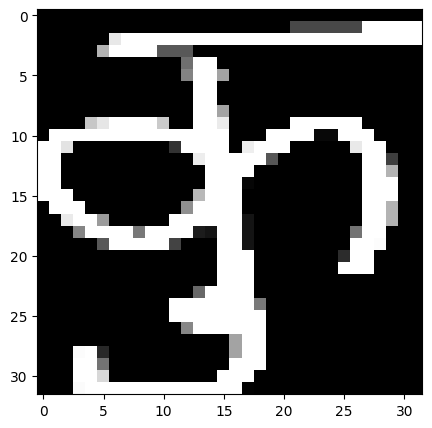

1/1 [==============================] - 0s 99ms/step


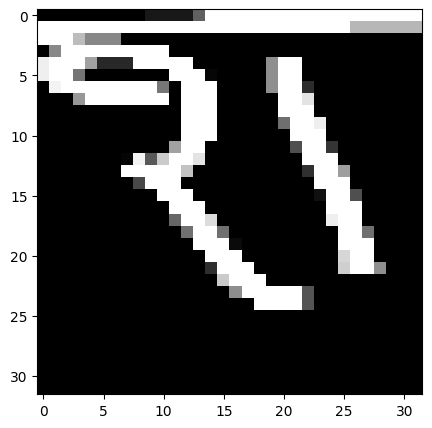

1/1 [==============================] - 0s 86ms/step


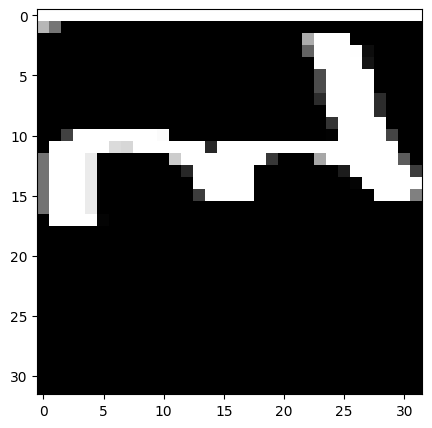

1/1 [==============================] - 0s 83ms/step


('कु श ल', 99.3064820766449)

In [ ]:
def classifier(segments):
    pred_lbl = ""
    acc = []
    for segment in segments:
        segment = cv2.resize(segment, (32, 32))
        # segment = cv2.GaussianBlur(segment, (3, 3), 0)
        # segment = cv2.erode(segment, (3, 3), 1)
        show(segment)

        lbl, a = prediction(segment)
        pred_lbl+=lbl
        acc.append(a)
    return pred_lbl, np.array(acc).mean()
classifier(segments[0])
